In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"
from jax import jit, numpy as jnp, lax
from jax.tree_util import register_pytree_node_class
import matplotlib.pyplot as plt
from functools import partial

print = partial(print, flush=True)
from dataclasses import dataclass

np.set_printoptions(suppress=True, precision=5)

In [28]:
def make_phonon_basis(n_sites, max_phonons):
    basis = []
    coefficients = [1 for _ in range(n_sites)]
    for i in range(max_phonons + 1):
        basis += frobenius(n_sites, coefficients, i)
    return basis


def frobenius(n, coefficients, target):
    """
    Enumerates solutions of the Frobenius equation with n integers.

    Args:
    - n: int, number of integers in the solution
    - coefficients: list of ints, coefficients for the Frobenius equation
    - target: int, target value for the Frobenius equation

    Returns:
    - list of tuples, each tuple represents a solution of the Frobenius equation
    """
    dp = [0] + [-1] * target  # Initialize the dynamic programming array

    for i in range(1, target + 1):
        for j in range(n):
            if coefficients[j] <= i and dp[i - coefficients[j]] != -1:
                dp[i] = j
                break

    if dp[target] == -1:
        return []  # No solution exists

    solutions = []
    current_solution = [0] * n

    def get_solution(i, remaining):
        if i == -1:
            if remaining == 0:
                solutions.append(jnp.array(current_solution))
            return

        for j in range(remaining // coefficients[i], -1, -1):
            current_solution[i] = j
            get_solution(i - 1, remaining - j * coefficients[i])

    get_solution(n - 1, target)
    return solutions


@dataclass
@register_pytree_node_class
class one_dimensional_chain:
    n_sites: int
    shape: tuple = (1,)

    def __post_init__(self):
        self.shape = (self.n_sites,)
        self.sites = tuple([(i,) for i in range(self.n_sites)])

    def get_site_num(self, pos):
        return pos[0]

    def make_polaron_basis(self, max_n_phonons):
        phonon_basis = make_phonon_basis(self.n_sites, max_n_phonons)
        polaron_basis = tuple(
            [(i,), phonon_state]
            for i in range(self.n_sites)
            for phonon_state in phonon_basis
        )
        return polaron_basis

    def __hash__(self):
        return hash(tuple(self.__dict__.values()))

    def tree_flatten(self):
        return (), tuple(self.__dict__.values())

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*aux_data)

In [29]:
# assumes x and y have equal momentum
@partial(jit, static_argnums=(5,))
def ham_element_kq(x, y, e_k, omega_q, g_kq, lattice):
    x_elec = x[0]
    x_phonon = x[1:]
    y_elec = y[0]
    y_phonon = y[1:]
    lattice_shape = jnp.array(lattice.shape)
    diff = x_phonon - y_phonon
    diff_sites = jnp.where(x_phonon == y_phonon, 0, 1)
    diff_count = jnp.sum(diff_sites)

    # diagonal term
    diag = (
        (jnp.sum(x_elec - y_elec) == 0)
        * (diff_count == 0)
        * (jnp.sum(omega_q * x_phonon) + e_k[x_elec])
    )
    # off-diagonal term
    elec_k_change = (x_elec - y_elec) % lattice_shape
    k_i = lattice.get_site_num([y_elec])
    q_i = lattice.get_site_num(elec_k_change)
    # phonon addition
    q_c = (y_elec - x_elec) % lattice_shape
    off_diag_1 = (
        (diff_count == 1)
        * (jnp.sum(diff) == 1)
        * g_kq[k_i, q_i]
        * jnp.sqrt(y_phonon[q_c] + 1)
    )
    # phonon removal
    q_d = (x_elec - y_elec) % lattice_shape
    off_diag_2 = (
        (diff_count == 1)
        * (jnp.sum(diff) == -1)
        * g_kq[k_i, q_i]
        * jnp.sqrt(y_phonon[q_d])
    )
    return diag + off_diag_1 + off_diag_2

In [23]:
n_sites = 6
omega_0 = 1.0
g = 1.0
t = 1.0
max_n_phonons = 8
lattice = one_dimensional_chain(n_sites)

# k space
omega_q = np.array([omega_0 for _ in range(n_sites)])
e_k = t * np.array([-2.0 * np.cos(2.0 * np.pi * k / n_sites) for k in range(n_sites)])
g_kq = np.array([[-g / n_sites**0.5 for _ in range(n_sites)] for _ in range(n_sites)])

basis = lattice.make_polaron_basis(max_n_phonons=max_n_phonons)
# separate basis based on k
bases_k = [[] for _ in range(n_sites)]
states_k = []
energies_k = []
basis_dict = {}
counters = [0 for _ in range(n_sites)]
counter = 0
for b in basis:
    phonon_k = np.zeros(len(lattice.shape), dtype=int)
    for site in lattice.sites:
        phonon_k += b[1][site] * np.array(site)
    total_k = (np.array(b[0]) + phonon_k) % np.array(lattice.shape)
    flat_basis_state = np.concatenate([np.array(b[0]), b[1].flatten()])
    bases_k[np.sum(total_k)].append(flat_basis_state)
    basis_dict[(b[0], tuple(np.array(b[1])))] = [
        np.sum(total_k),
        counters[np.sum(total_k)],
    ]
    counters[np.sum(total_k)] += 1

ham_element = partial(
    ham_element_kq, e_k=e_k, omega_q=omega_q, g_kq=g_kq, lattice=lattice
)
for k_i in range(n_sites):
    basis_k = bases_k[k_i]
    basis_k = jnp.array(basis_k)

    def scan_inner(carry, x):
        def inner(carry, y):
            return carry, ham_element(x, y)

        _, result = lax.scan(inner, None, basis_k)
        return carry, result

    _, ham_mat = lax.scan(scan_inner, None, basis_k)
    ham_mat = ham_mat.reshape(ham_mat.shape[0], ham_mat.shape[1])
    print(f"Built hamiltonian for k = {k_i} with shape {ham_mat.shape}")
    energies, states = jnp.linalg.eigh(ham_mat)
    print(energies[:5], "\n")
    states_k.append(states)
    energies_k.append(energies)

Built hamiltonian for k = 0 with shape (3003, 3003)
[-2.47148 -1.47148 -1.07067 -0.79321 -0.69204] 

Built hamiltonian for k = 1 with shape (3003, 3003)
[-1.92271 -1.22414 -0.92269 -0.86268 -0.75643] 

Built hamiltonian for k = 2 with shape (3003, 3003)
[-1.64402 -1.14463 -1.01436 -0.76459 -0.64398] 

Built hamiltonian for k = 3 with shape (3003, 3003)
[-1.60176 -1.12764 -1.01193 -0.60171 -0.50666] 

Built hamiltonian for k = 4 with shape (3003, 3003)
[-1.64402 -1.14463 -1.01435 -0.76459 -0.64398] 

Built hamiltonian for k = 5 with shape (3003, 3003)
[-1.92271 -1.22414 -0.92269 -0.86268 -0.75643] 



In [24]:
eta = 0.05
omega = np.linspace(-4, 6, 1000)
specs_t = []

for beta in [1 / 0.1]:
    z = 0.0
    specs = np.array([0.0 * omega for _ in range(n_sites)])
    for b in basis:
        energy_phonon = np.sum(omega_q * b[1])
        kpp, n = basis_dict[(b[0], tuple(np.array(b[1])))]
        if kpp > n_sites // 2:
            b_flipped = [
                ((1 - (b[0][0] == 0)) * (n_sites - b[0][0]),),
                np.concatenate([b[1][:1], np.flip(b[1][1:])]),
            ]
            kpp, n = basis_dict[(b_flipped[0], tuple(np.array(b_flipped[1])))]
        k = b[0][0]
        energies_kpp = energies_k[kpp]
        states_kpp = states_k[kpp]
        weights = np.abs(states_kpp[n, :]) ** 2
        reshaped_omega = omega.reshape(-1, 1)
        reshaped_energies = energies_kpp.reshape(1, -1)
        denominator = (reshaped_omega - reshaped_energies + energy_phonon) ** 2 + eta**2
        lorentzian = eta / (denominator * np.pi)
        specs[k] += np.sum(weights * lorentzian, axis=1) * np.exp(-beta * energy_phonon)
        z += np.exp(-beta * energy_phonon) / n_sites
    specs /= z
    specs_t.append(specs)

Text(0.5, 0, '$\\omega$')

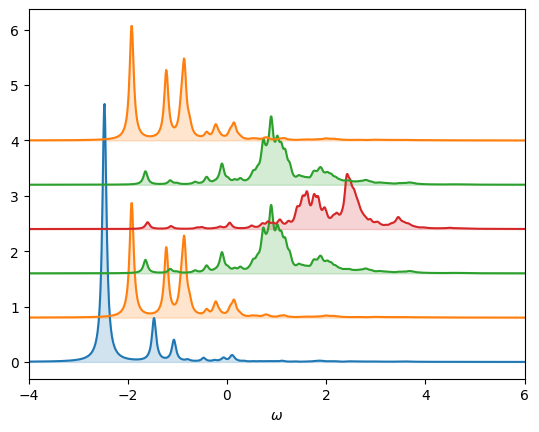

In [26]:
specs = specs_t[0]
shift = 0.8
for k in range(specs.shape[0]):
    kp = k
    if kp > specs.shape[0] // 2:
        kp = (1 - (k == 0)) * (specs.shape[0] - k)
    plt.fill_between(omega, specs[k] + shift * k, shift * k, color=f"C{kp}", alpha=0.2)
    plt.plot(omega, specs[k] + shift * k, color=f"C{kp}", linestyle="-", alpha=1.0)
plt.xlim(-4, 6)
plt.xlabel(r"$\omega$")